In [203]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

# from tslearn.metrics import dtw as time_warping

import ordpy
import tqdm
import igraph


from numpy import linalg as LA
from scipy.signal import find_peaks

In [204]:
#Statistical Learning
from sklearn.cluster import KMeans

#model selectionfrom sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import validation_curve
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import cross_val_score

#evaluation
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

#dimensionality reduction
from sklearn.decomposition import PCA

# Functions' definitions

In [205]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [206]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [207]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [208]:
def full_ordinal_distribution(data, dx=3, taux=1, multi=False):
    """
    Ordinal probability distribution. Ordered and with 
    permutations with zero probability.
    
    Parameter
    ---------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 
    ---------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.

    """
    if multi==False:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data)
        except:
            nx     = np.shape(data)[0]
            ny     = 1
            data   = np.array([data])
            
        partitions = np.concatenate(
            [
                [np.concatenate(data[j:j+1:1,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
                for j in range(ny)
            ]
        )

        symbols = np.apply_along_axis(np.argsort, 1, partitions)
        symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

        probabilities = symbols_count/len(partitions)
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs
        
    else:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data).T
        except:
            return None

        partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
        flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
        flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

        probabilities = symbols_count/symbols_count.sum()
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, flat_symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs

    
def fisher_shannon(data, dx=3, taux=1, probs=False, multi=False):
    """
    Calculates permutation entropy\\ [#bandt_pompe]_ and Fisher 
    information using an ordinal distribution obtained from data.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 

    Returns
    -------
     : tuple
       Values of permutation entropy and Fisher information.
    """  
    if multi==False:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2)  # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2
        
    else:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux, multi=True)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2

        
def multi_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Calculates Shannon's entropy using an ordinal ditribution obtained from
    a multidimensional time series.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

    probabilities = symbols_count/symbols_count.sum()

    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))
        else:
            return -np.sum(probabilities*np.log(probabilities))

In [291]:
dx, taux = 2, 1
data = np.asarray([[0,1,2,4,5], [4,3,2,5,6], [5,6,1,5,4]])

In [292]:
try:
    ny, nx = np.shape(data)
    data   = np.array(data).T
except:
    return None

if tie_precision is not None:
    data = np.round(data, tie_precision)

partitions         = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions)

distributions = []
sum_of_entropies = 0.

for sequence_ in symbolic_sequences:
    symbols, symbols_count = np.unique(sequence_, return_counts=True, axis=0)
    probabilities          = symbols_count/symbols_count.sum()
    
    sum_of_entropies += -np.sum(probabilities*np.log(probabilities))/symbolic_sequences.shape[0]

    flat_symbols      = np.apply_along_axis(np.array2string, 1, symbols, separator='')
    
    full_symbols     = np.asarray(list(itertools.permutations(np.arange(dx))))
    full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
    full_probs       = np.full(len(full_symbols), 0.)

    for symbol_, probs_ in zip(flat_symbols, probabilities):
        index             = np.argwhere(symbol_==full_symbols_str).flatten()
        full_probs[index] = probs_
    
    distributions.append(full_probs)

sum_of_distr   = np.sum(distributions, axis=0)/symbolic_sequences.shape[0]
entropy_of_sum = -np.sum(sum_distributions*np.log(sum_distributions))

return np.sqrt(entropy_of_sum - sum_of_entropies) 

In [ ]:
def permutation_js_distance(data, dx=3, taux=1, base=2, tie_precision=None):
    """
    Calculates permutation Jensen-Shannon distance between multiple
    time series using an ordinal distribution obtained from data.
    
    Parameters
    ---------
    data : array
           Array object in the forma :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` representing an 
           m-dimensional time series of length n or m time series of length n.
           
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    ----------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions         = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions)

    full_distributions = []
    sum_of_entropies = 0.

    for sequence_ in symbolic_sequences:
        symbols, symbols_count = np.unique(sequence_, return_counts=True, axis=0)
        probabilities          = symbols_count/symbols_count.sum()

        sum_of_entropies += -np.sum(probabilities*np.log(probabilities))/symbolic_sequences.shape[0]

        flat_symbols      = np.apply_along_axis(np.array2string, 1, symbols, separator='')

        full_symbols     = np.asarray(list(itertools.permutations(np.arange(dx))))
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        full_distributions.append(full_probs)

    sum_of_distr   = np.sum(full_distributions, axis=0)/symbolic_sequences.shape[0]
    entropy_of_sum = -np.sum(sum_of_distr*np.log(sum_of_distr))

    return np.sqrt(entropy_of_sum - sum_of_entropies) 

#log_function, pra modificar o parâmetro base
#verificar normalização

In [209]:
def mwpe(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [210]:
def weighted_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    data   = np.asarray(data)
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [211]:
def trajectory_cleaning(shape):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "Circle", 
                 "Square" or "Cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm in horizontal position,
      1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['data'][0])):
        disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['data'][0])):
        disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses dropped
    if shape=='Cross':
        disk_width = []
        for i in range(len(disk_data['data'][0])):
            disk_width.append(disk_data['data'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['data'][0])):
        disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################

    
    #Cleaning trajectories
    clean_disk_trajectories = []
    clean_disk_cam2         = []
    clean_disk_cam1         = []
    
    clean_disk_initcons     = []
    clean_disk_class        = []
    clean_disk_radii        = []
    clean_disk_width        = []

    for i in range(len(disk_trajectories)):
        #vertical trajectory
        z         = disk_trajectories[i][::,2][::-1]

        #finding the index to remove the last 5cm of fall
        cut_index = 0
        for z_ in z:
            if z_<0.05:
                cut_index -= 1
            else: break

        if not cut_index==0:
            # removing the last 5 centimeters of the fall.
            trajectory = disk_trajectories[i][:cut_index].copy() 

            #removing  the last 5cm of fall from observable area series
            area_cam2 = disk_cam2[i][:cut_index].copy()
            area_cam1 = disk_cam1[i][:cut_index].copy()
        else:
            trajectory = disk_trajectories[i].copy() 
            area_cam2  = disk_cam2[i].copy()
            area_cam1  = disk_cam1[i].copy()


    #(original comment) Segment steady and periodic behaviours from trajectories. 
        if disk_initcons[i]==0: #(original comment) We only see steady and periodic from horizontal initial condition.
            tc=0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<(0.2*disk_radii[i]) and tc<len(trajectory[::,1]):
                tc=tc+1

            if tc>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
    #             pass
    #             print(steady_index)
                clean_disk_trajectories.append(trajectory[:tc+1])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(3)
                clean_disk_cam1.append(area_cam1[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                clean_disk_cam2.append(area_cam2[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass
    #             print('dividiu: ', i)
    #             print('counter steady:', counter)

                if len(trajectory)-tc>10: #second part of the sliced original trajectory.
                    clean_disk_trajectories.append(trajectory[tc:])
                    clean_disk_initcons.append(0)
                    clean_disk_radii.append(disk_radii[i])
                    clean_disk_class.append(np.nan)
                    clean_disk_cam1.append(area_cam1[tc:])
                    clean_disk_cam2.append(area_cam2[tc:])
                    # width of the crosses dropped
                    if shape=='Cross':
                        clean_disk_width.append(disk_width[i])
                    else: pass

            else: #no segmentation; only one behavior throughout the whole fall
                clean_disk_trajectories.append(trajectory)
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1)
                clean_disk_cam2.append(area_cam2)
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass


        else: #(original comment) Vertical initial condition, no steady and peridoic behaviour
            tc = 0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<0.01 and tc<len(trajectory[::,1]):
                tc = tc+1

            if len(trajectory[::,1])-tc>10:
                clean_disk_trajectories.append(trajectory[tc:])
                clean_disk_initcons.append(1)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[tc:])
                clean_disk_cam2.append(area_cam2[tc:])
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass

    if shape=='Cross':
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_width, clean_disk_initcons, clean_disk_class
    else:
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_initcons, clean_disk_class

def original_features(trajectories, area_cam1, area_cam2):
    """
    Extracts physical measures from time series of 
    falling paper. For more information, see Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    trajectories (array): set of time series of  trajectories of 
                          falling papers.
    ----------
    Returns several arrays containing 
    characteristics of falling papers:
    
    - displacement in the x axis; 
    - displacement in the y axis; 
    - displacement in the z axis; 
    - length of the trajectory;
    - duration of the fall;
    - angular velocity;
    - standard deviation of the velocity of fall
    in the z axis;
        
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    clean_disk_trajectories = trajectories
    clean_disk_cam1         = area_cam1
    clean_disk_cam2         = area_cam2
    
    dx         = []
    dy         = []
    dz         = []
    pathlength = []
    time       = []
#     X          = []
    Osc        = []
    SpeedZ     = []
    
    for i in range(len(clean_disk_trajectories)):
        stop = 0
        d    = 0 

        for j in range(1, len(clean_disk_trajectories[i])):
            if LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])>0.1:
                stop==1
                break
            d = d + LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])

        if stop==0:
            pathlength.append(d)
            z = clean_disk_trajectories[i][::,2]
            dz.append(np.absolute(clean_disk_trajectories[i][::,2][-1]-clean_disk_trajectories[i][::,2][0]))
            dy.append(clean_disk_trajectories[i][::,1][-1]-clean_disk_trajectories[i][::,1][0])
            dx.append(clean_disk_trajectories[i][::,0][-1]-clean_disk_trajectories[i][::,0][0])
            time.append(len(clean_disk_trajectories[i])*1/98)

            locs1 = find_peaks(clean_disk_cam1[i])[0]
            locs2 = find_peaks(clean_disk_cam2[i])[0]

            Osc.append((len(locs1)+len(locs2))/(2*time[-1]))
            SpeedZ.append(np.std(np.diff(z)))
#             X.append([Osc, SpeedZ])

    return dx, dy, dz, pathlength, time, Osc, SpeedZ

# Disk Analysis

In [80]:
def trajectory_reshaping(shape='circle'):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "circle", "hexagon"
                 "square" or "cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm in horizontal position,
      1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/{}_cleaned.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_initcons.append(disk_data['dataProcessed'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_radii.append(disk_data['dataProcessed'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses
    if shape=='cross':
        disk_width = []
        for i in range(len(disk_data['dataProcessed'][0])):
            disk_width.append(disk_data['dataProcessed'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_cam1.append(disk_data['dataProcessed'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_cam2.append(disk_data['dataProcessed'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_trajectories.append(disk_data['dataProcessed'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################
    
    if shape=='Cross':
        return  disk_trajectories, disk_cam1, disk_cam2, disk_radii, disk_width, disk_initcons
    else:
        return  disk_trajectories, disk_cam1, disk_cam2, disk_radii, disk_initcons

In [212]:
shape_ = 'Circle'

#loading cleaned trajectories and some features.
circle_trajectories, circle_cam1, circle_cam2, circle_radii, circle_conditions, _  = trajectory_cleaning(shape_)
circle_dx, circle_dy, circle_dz, circle_pathlen, circle_time, circle_w, circle_vz  = original_features(circle_trajectories, circle_cam1, circle_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [213]:
#Classifications
circle_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Circle'))['behaviourHuman'][0]
circle_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Circle'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [88]:
# #Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten()==np.asarray(circle_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten()==np.asarray(circle_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten()==np.asarray(circle_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), circle_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), circle_time,
#                             range(len(circle_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Disk - Original features plane (angular velocity vs linear velocity)

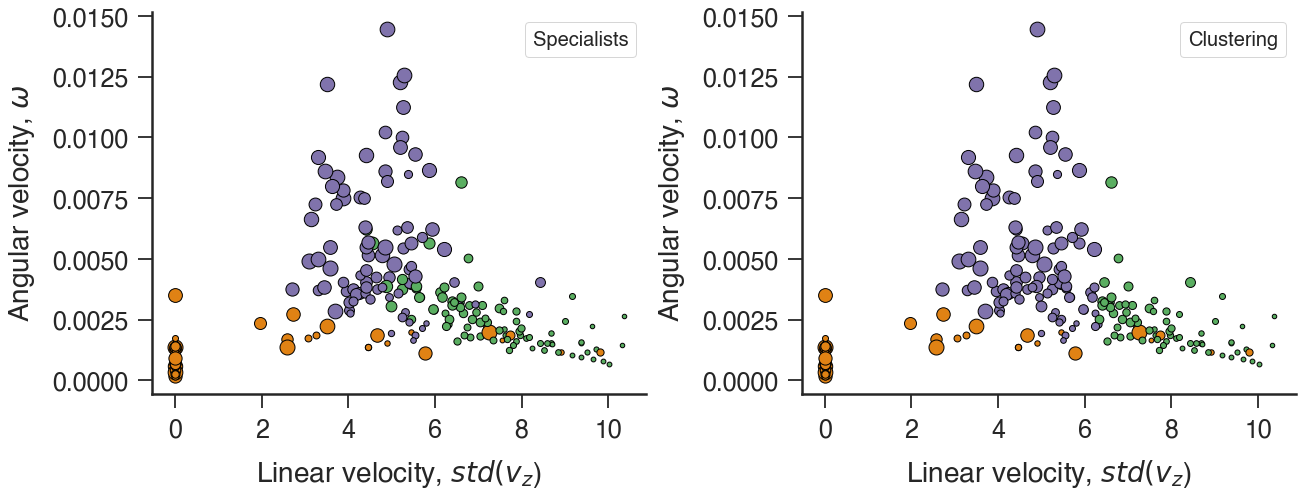

In [21]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214" #periodic
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_human_class, circle_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_feat_class, circle_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Disk - Complexity-entropy or Fisher-Shannon plane

Text(0, 0.5, 'Raw frequency')

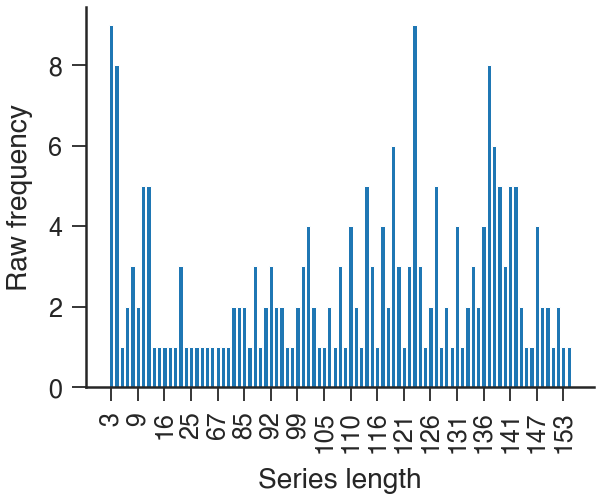

In [298]:
#Disk size histogram
f, ax = plt.subplots()

x, y = np.unique([len(i) for i in circle_trajectories], return_counts=True)
# y    = y/y.sum()
# x    = range(len(x))

# plt.plot(x, y, 'o')
ax.bar(range(len(x)), y)

ax.set_xticks(range(len(x))[::5])
x = x.round(decimals=3)[::5]
x = x.round(decimals=3)
ax.set_xticklabels(x.astype('str'), rotation=90)

ax.set_xlabel('Series length')
ax.set_ylabel('Raw frequency')

Text(0, 0.5, 'Raw frequency')

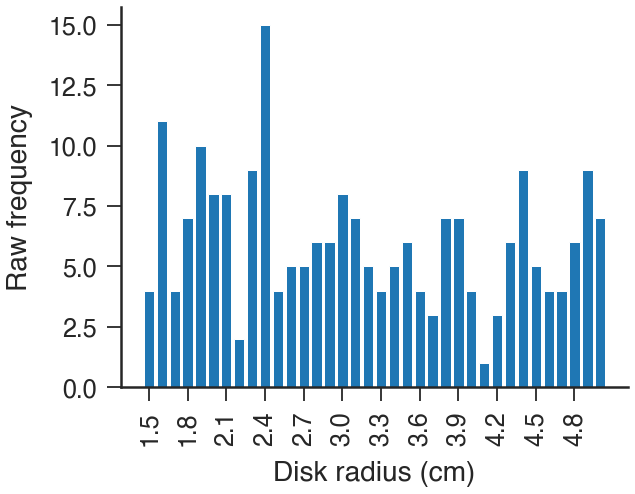

In [285]:
#Disk size histogram
f, ax = plt.subplots()


x, y = np.unique(circle_radii, return_counts=True)
# y    = y/y.sum()
# x    = range(len(x))

# plt.plot(x, y, 'o')
ax.bar(range(len(x)), y)
ax.set_xticks(range(len(x))[::3])

x = 100*x.round(decimals=3)[::3]
x = x.round(decimals=3)
ax.set_xticklabels(x.astype('str'), rotation=90)

ax.set_xlabel('Disk radius (cm)')
ax.set_ylabel('Raw frequency')

/home/arthur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


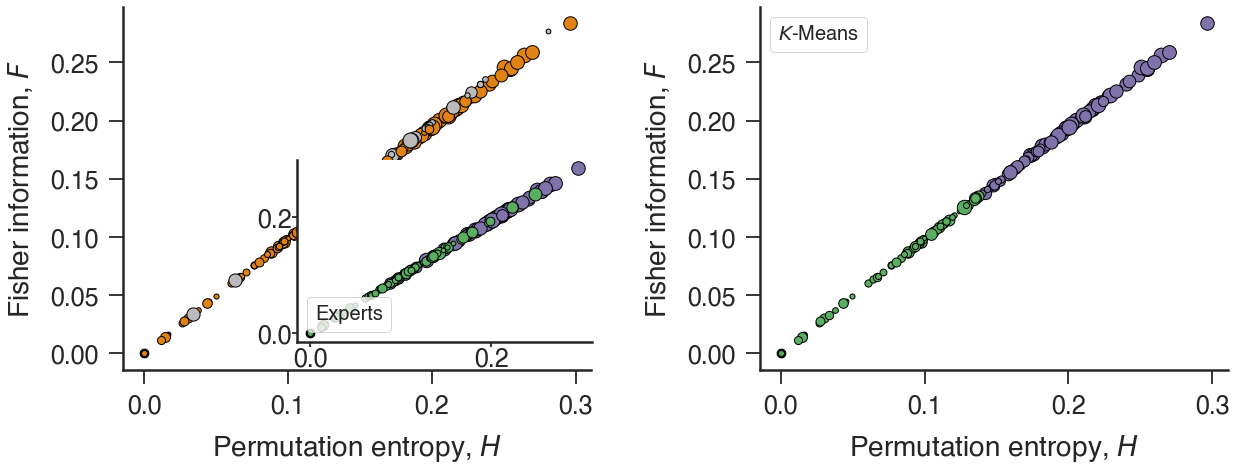

In [174]:
dx_                     = 7
circle_ce               = []
circle_cluster          = []
circle_size             = []
circle_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_trajectories, 
                                          circle_cam1, circle_cam2, circle_human_class, circle_radii):
#Complexity-Entropy plane
    if class_==3:
        try:
#             ts     = np.stack((ts1, ts2), axis=1)
            ts     = st 
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            circle_ce.append((h_, c_))
        except:
            circle_ce.append((np.nan, np.nan))
    else:
#         ts     = np.stack((ts1, ts2), axis=1)
        ts     = st 
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        circle_ce.append((h_, c_))
        circle_cluster.append((h_, c_))
        circle_size.append(size_)
        circle_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
axins = inset_axes(ax[0], width="90%", height="100%",
                   bbox_to_anchor=(.35, .05, .7, .5),
                   bbox_transform=ax[0].transAxes, loc=3)
axins.tick_params(length=5, pad=0)
# axins.spines['left'].set_smart_bounds(True)
# axins.spines['bottom'].set_smart_bounds(True)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

# for (h_, c_), class_, size_ in zip(circle_ce, circle_feat_class, circle_radii):
for (h_, c_), class_, size_ in zip(circle_ce, circle_human_class, circle_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_)
        axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
        axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    if class_ == 3:
        try:
            ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_)
        except:
            pass
        
        
#clustering to generate the second panel data
circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster).labels_ 

for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size):
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    else:
        ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
axins.legend(['Experts'], loc='lower left', handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Fisher information, $F$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/Fisher-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

In [168]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
np.where(circle_human_class==3)[0].flatten()==np.where(circle_feat_class==3)[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [176]:
_, b = np.unique(circle_human_class[circle_human_class!=3], return_counts=True)
b    = b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=1)[0]*100))
print('Chaotic  = {}%'.format(b.round(decimals=1)[1]*100), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
circle_pred_copy = np.where(circle_pred==0, 2, circle_pred)

# circle_pred_copy = np.where(circle_pred==1, 2, circle_pred)
# circle_pred_copy = np.where(circle_pred==0, 1, circle_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(circle_human_chaos_tumb==circle_pred_copy)/len(circle_pred_copy))
print('Accuracy of the original paper                          : ', sum(circle_feat_class[circle_feat_class!=3]==circle_human_class[circle_human_class!=3])/len(circle_feat_class[circle_feat_class!=3]))

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 50.0%
Chaotic  = 50.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.8470588235294118
Accuracy of the original paper                          :  0.8529411764705882


In [ ]:
# Vários valores de "embedding dimension" para duas câmeras
print("Os resultados para os papéis em forma de círculo são consistentes. Eles se mantém estáveis (até com melhoras) para dx entre 3 e 6.")
print("dx=3, ~.835. dx=4, ~.882. dx=5, ~882. dx=6, ~.864")

# Vários valores de "embedding dimension" para a "câmera 1".
print("dx = 3, ~.847. dx = 4, ~.864z. dx = 5, ~.871. dx=6, ~.865.")

# Vários valores de "embedding dimension" para a "câmera 2".
print("dx = 3, ~.829. dx = 4, ~.812. dx = 5, ~.817. dx=6, ~.865.")

## 3D - Disk

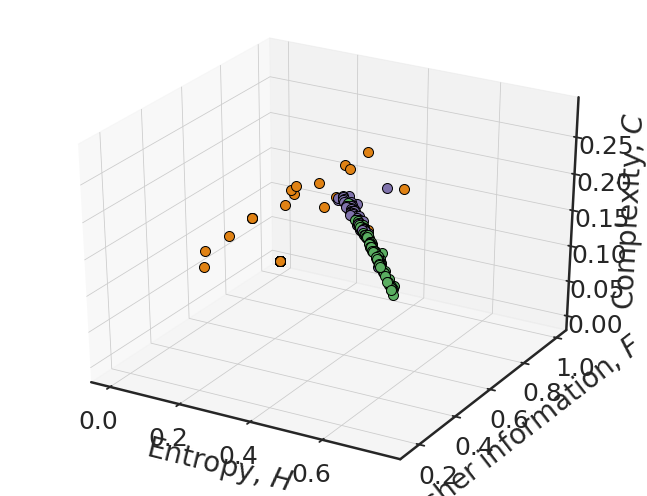

In [227]:
dx_ = 3

pe3d                  = []
pe3d_space            = []
pe3d_human_chaos_tumb = []

for i, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_cam1, 
                                      circle_cam2, circle_human_class, circle_radii):
    if class_==3: #steady or periodic
        try:
            ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            pe3d.append((np.nan, np.nan))
            
    else: #chaotic or tumbling
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_space.append((h_, f_, c_))
        pe3d_human_chaos_tumb.append(class_)

###################################################################        
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

orange_ = "#e08214" #3
purple_ = "#8073ac" #2
green_  = "#5aae61" #1
#(h_, f_, c_)
# for (x_, y_, z_), class_ in zip(pe3d, circle_feat_class): 
for (x_, y_, z_), class_ in zip(pe3d, circle_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color=green_, edgecolor='black')
#         ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color=green_, zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='o', s=100, color=purple_, edgecolor='black')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='o', s=100, color=orange_, edgecolor='black', zorder=0)
        except:
            pass

ax.set_xlabel('Entropy, $H$')
ax.set_ylabel('Fisher information, $F$')
ax.set_zlabel('Complexity, $C$')



#calculation to generate second panel data
pe3d_space = np.asarray(pe3d_space).reshape(-1,3)
pe3d_pred  = KMeans(n_clusters=2, random_state=42).fit(pe3d_space).labels_ 


f.tight_layout()

In [228]:
pe3d_pred_copy_plus_1 = pe3d_pred.copy()+1

sum(pe3d_human_chaos_tumb==pe3d_pred_copy_plus_1)/len(pe3d_pred_copy_plus_1)

0.8823529411764706

In [229]:
pe3d_pred_copy = np.where(pe3d_pred==0, 2, pe3d_pred)

sum(pe3d_human_chaos_tumb==pe3d_pred_copy)/len(pe3d_pred_copy)

0.11764705882352941

In [230]:
# Agreement between the human and the permutation entropy classification
circle_pred = np.where(circle_pred==0, 2, circle_pred)

sum(circle_pred==circle_human_chaos_tumb)/len(circle_pred)

0.8352941176470589

In [231]:
# # Agreement between the human and the permutation entropy classification
# square_pred_copy = square_pred.copy()+1

# sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy)

# Agreement between the human and the permutation entropy classification
pe3d_pred_copy_plus_1 = pe3d_pred.copy()+1

print('Score permutation entropy strategy: ', sum(pe3d_human_chaos_tumb==pe3d_pred_copy_plus_1)/len(pe3d_pred_copy_plus_1), '\n')

print('Score of the original paper strategy: ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]))

Score permutation entropy strategy:  0.8823529411764706 

Score of the original paper strategy:  0.8478260869565217


# Hexagon

In [56]:
shape_ = "Hexagon"

hex_trajectories, hex_cam1, hex_cam2, hex_radii, hex_conditions, _       = trajectory_cleaning(shape_)
hex_trajectories = np.delete(hex_trajectories, [38, 143, 144])
hex_cam1         = np.delete(hex_cam1, [38, 143, 144])
hex_cam2         = np.delete(hex_cam2, [38, 143, 144])
hex_radii        = np.delete(hex_radii, [38, 143, 144])
hex_conditions   = np.delete(hex_conditions, [38, 143, 144])

# hex_trajectories = np.delete(hex_trajectories, [142])
# hex_cam1         = np.delete(hex_cam1, 142)
# hex_cam2         = np.delete(hex_cam2, 142)
# hex_radii        = np.delete(hex_radii, 142)
# hex_conditions   = np.delete(hex_conditions, 142)

# hex_trajectories = np.delete(hex_trajectories, [39, 143, 142])
# hex_cam1         = np.delete(hex_cam1, [39, 143, 142])
# hex_cam2         = np.delete(hex_cam2, [39, 143, 142])
# hex_radii        = np.delete(hex_radii, [39, 143, 142])
# hex_conditions   = np.delete(hex_conditions, [39, 143, 142])

hex_dx, hex_dy, hex_dz, hex_pathlen, hex_time, hex_w, hex_vz             = original_features(hex_trajectories, hex_cam1, hex_cam2)

In [57]:
saved_dx         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten(), 142)
saved_dy         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten(), 142)
saved_dz         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten(), 142)
saved_pathlength = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), 142)
saved_time       = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), 142)

In [53]:
test_hex_trajectories, test_hex_cam1, test_hex_cam2, test_hex_radii, test_hex_conditions, _ = trajectory_cleaning(shape_)

In [63]:
hex_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape_))['behaviourHuman'][0]
hex_human_class = np.delete(hex_human_class, [142])

hex_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['behaviourAuto'].flatten()
hex_feat_class  = np.delete(hex_feat_class, [142])

In [62]:
#Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

for a, b, c, d, e, f, g,  k in zip(saved_dx==np.asarray(hex_dx), 
                                   saved_dy==np.asarray(hex_dy), 
                                   saved_dz==np.asarray(hex_dz), 
                                   saved_pathlength, hex_pathlen,
                                   saved_time, hex_time,
                                   range(len(hex_dx))):

    print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

True True True True True 0
True True True True True 1
True True True True True 2
True True True True True 3
True True True True True 4
True True True True True 5
True True True True True 6
True True True True True 7
True True True True True 8
True True True True True 9
True True True True True 10
True True True True True 11
True True True True True 12
True True True True True 13
True True True True True 14
True True True True True 15
True True True True True 16
True True True True True 17
True True True True True 18
True True True True True 19
True True True True True 20
True True True True True 21
True True True True True 22
True True True True True 23
True True True True True 24
True True True True True 25
True True True True True 26
True True True True True 27
True True True True True 28
True True True True True 29
True True True True True 30
True True True True True 31
True True True True True 32
True True True True True 33
True True True True True 34
True True True True True 35
Tr

## Hexagon - Original features plane (angular velocity vs linear velocity)

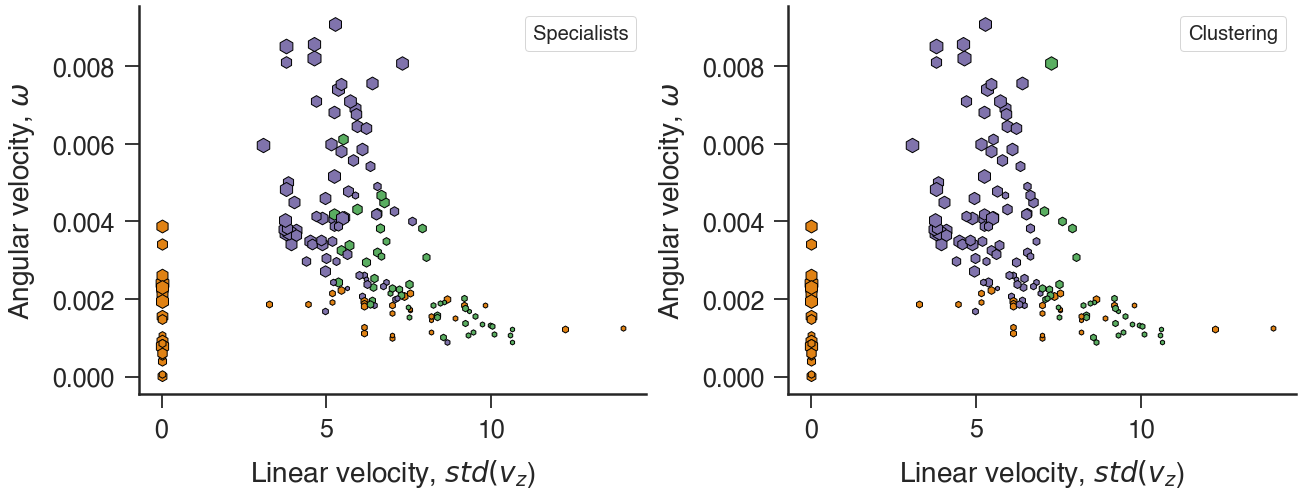

In [61]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214"
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_human_class, hex_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_feat_class, hex_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Hexagon - Complexity-entropy or Fisher-Shannon plane

Text(0, 0.5, 'Raw frequency')

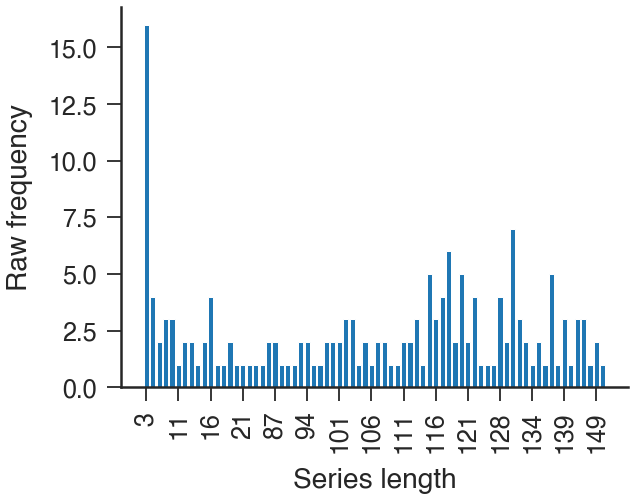

In [65]:
#Disk size histogram
f, ax = plt.subplots()

x, y = np.unique([len(i) for i in hex_trajectories], return_counts=True)
# y    = y/y.sum()
# x    = range(len(x))

# plt.plot(x, y, 'o')
ax.bar(range(len(x)), y)

ax.set_xticks(range(len(x))[::5])
x = x.round(decimals=3)[::5]
x = x.round(decimals=3)
ax.set_xticklabels(x.astype('str'), rotation=90)

ax.set_xlabel('Series length')
ax.set_ylabel('Raw frequency')

Text(0, 0.5, 'Raw frequency')

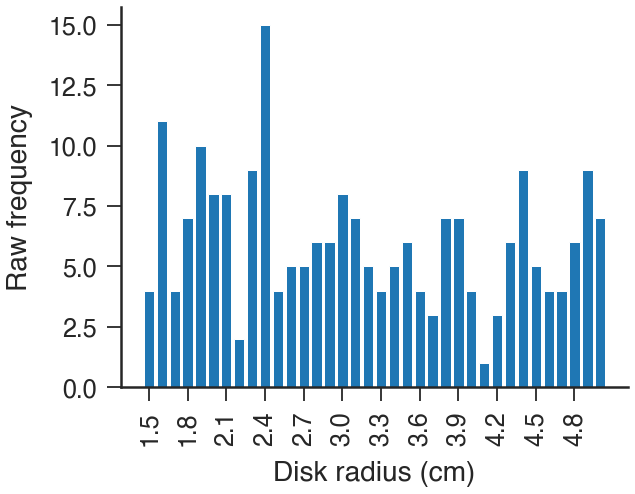

In [66]:
#Disk size histogram
f, ax = plt.subplots()


x, y = np.unique(circle_radii, return_counts=True)
# y    = y/y.sum()
# x    = range(len(x))

# plt.plot(x, y, 'o')
ax.bar(range(len(x)), y)
ax.set_xticks(range(len(x))[::3])

x = 100*x.round(decimals=3)[::3]
x = x.round(decimals=3)
ax.set_xticklabels(x.astype('str'), rotation=90)

ax.set_xlabel('Disk radius (cm)')
ax.set_ylabel('Raw frequency')

/home/arthur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


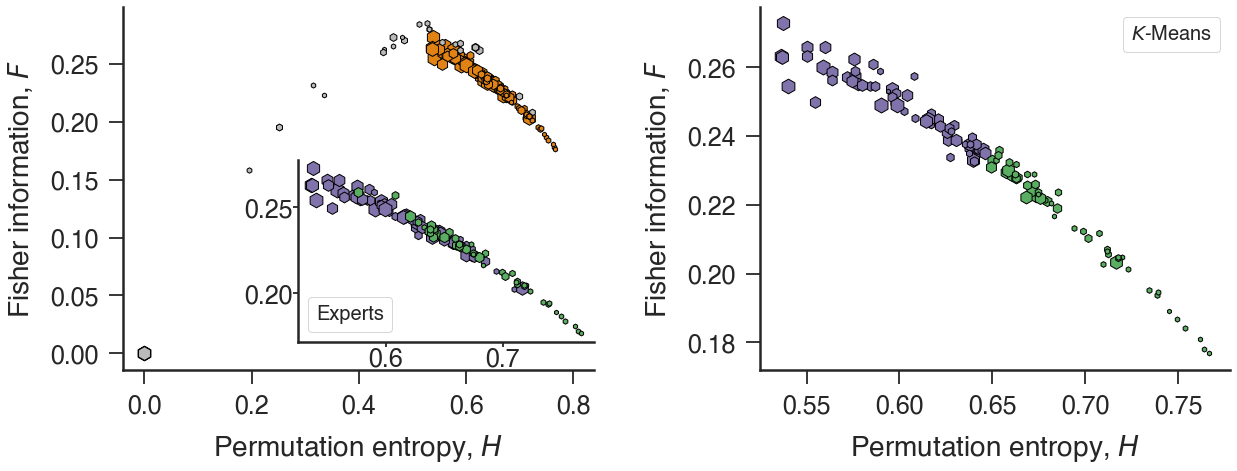

In [154]:
dx_                  = 3
hex_ce               = []
hex_cluster          = []
hex_size             = []
hex_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(hex_trajectories)), hex_trajectories, 
                                          hex_cam1, hex_cam2, hex_human_class, hex_radii):
#Complexity-Entropy plane
    if class_==3:
        try:
            ts = st
#             ts     = np.stack((ts1, ts2), axis=1)
#             p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#             h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
            hex_ce.append((h_, c_))
        except:
            hex_ce.append((np.nan, np.nan))
    else:
        ts = st
#         ts     = np.stack((ts1, ts2), axis=1)
#         p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        h_, c_ = ordpy.complexity_entropy(ts, dx=dx_, probs=False)
        hex_ce.append((h_, c_))
        hex_cluster.append((h_, c_))
        hex_size.append(size_)
        hex_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
axins = inset_axes(ax[0], width="90%", height="100%",
                   bbox_to_anchor=(.35, .05, .7, .5),
                   bbox_transform=ax[0].transAxes, loc=3)
axins.tick_params(length=5, pad=0)
# axins.spines['left'].set_smart_bounds(True)
# axins.spines['bottom'].set_smart_bounds(True)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

# for (h_, c_), class_, size_ in zip(hex_ce, hex_feat_class, hex_radii):
for (h_, c_), class_, size_ in zip(hex_ce, hex_human_class, hex_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_)
        axins.plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
        axins.plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    if class_ == 3:
        try:
            ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=grey_)
        except:
            pass
        
        
#clustering to generate the second panel data
hex_cluster          = np.asarray(hex_cluster).reshape(-1,2) #standardizing permutation features
hex_pred             = KMeans(n_clusters=2, random_state=42).fit(hex_cluster).labels_ 

for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_size):
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    else:
        ax[1].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
axins.legend(['Experts'], loc='lower left', handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Fisher information, $F$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/Fisher-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

In [155]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
np.where(hex_human_class==3)[0].flatten()==np.where(hex_feat_class==3)[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [156]:
_, b = np.unique(hex_human_class[hex_human_class!=3], return_counts=True)
b    = b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=1)[0]*100))
print('Chaotic  = {}%'.format(b.round(decimals=1)[1]*100), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
hex_pred_copy = np.where(hex_pred==0, 2, hex_pred)

# hex_pred_copy = np.where(hex_pred==1, 2, hex_pred)
# hex_pred_copy = np.where(hex_pred==0, 1, hex_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(hex_human_chaos_tumb==hex_pred_copy)/len(hex_pred_copy))
print('Accuracy of the original paper                          : ', sum(hex_feat_class[hex_feat_class!=3]==hex_human_class[hex_human_class!=3])/len(hex_feat_class[hex_feat_class!=3]))

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 40.0%
Chaotic  = 60.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.7416666666666667
Accuracy of the original paper                          :  0.7916666666666666


In [157]:
# two cameras, several embedding dimensions 
print("dx=3 ~.8; dx=4 ~.7916; dx=5 ~.7833; dx=6 ~.7417")

# "camera 1", several embedding dimensions 
print("dx=3 ~.85; dx=4 ~.8083; dx=5 ~.8417; dx=6 ~.7917")

# "camera 2", several embedding dimensions 
print("dx=3, ~.7417; dx=4 ~.725; dx=5 ~.7083; dx=6 ~.7083.")

dx=3 ~.8; dx=4 ~.7916; dx=5 ~.7833; dx=6 ~.7417
dx=3 ~.85; dx=4 ~.8083; dx=5 ~.8417; dx=6 ~.7917
dx=3, ~.7417; dx=4 ~.725; dx=5 ~.7083; dx=6 ~.7083.


# Square  Analysis

In [214]:
#loading cleaned trajectories and some features.
square_trajectories, square_cam1, square_cam2, square_radii, square_conditions, _  = trajectory_cleaning('Square')
square_dx, square_dy, square_dz, square_pathlen, square_time, square_w, square_vz  = original_features(square_trajectories, square_cam1, square_cam2)

In [215]:
#Classifications
square_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Square'))['behaviourHuman'][0]
square_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Square'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [131]:
# #Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dx'].flatten()==np.asarray(square_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dy'].flatten()==np.asarray(square_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dz'].flatten()==np.asarray(square_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['pathLength'].flatten(), square_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['time'].flatten(), square_time,
#                             range(len(square_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

True True True True True 0
True True True True True 1
True True True True True 2
True True True True True 3
True True True True True 4
True True True True True 5
True True True True True 6
True True True True True 7
True True True True True 8
True True True True True 9
True True True True True 10
True True True True True 11
True True True True True 12
True True True True True 13
True True True True True 14
True True True True True 15
True True True True True 16
True True True True True 17
True True True True True 18
True True True True True 19
True True True True True 20
True True True True True 21
True True True True True 22
True True True True True 23
True True True True True 24
True True True True True 25
True True True True True 26
True True True True True 27
True True True True True 28
True True True True True 29
True True True True True 30
True True True True True 31
True True True True True 32
True True True True True 33
True True True True True 34
True True True True True 35
Tr

## Square - Original features plane (angular velocity vs linear velocity)

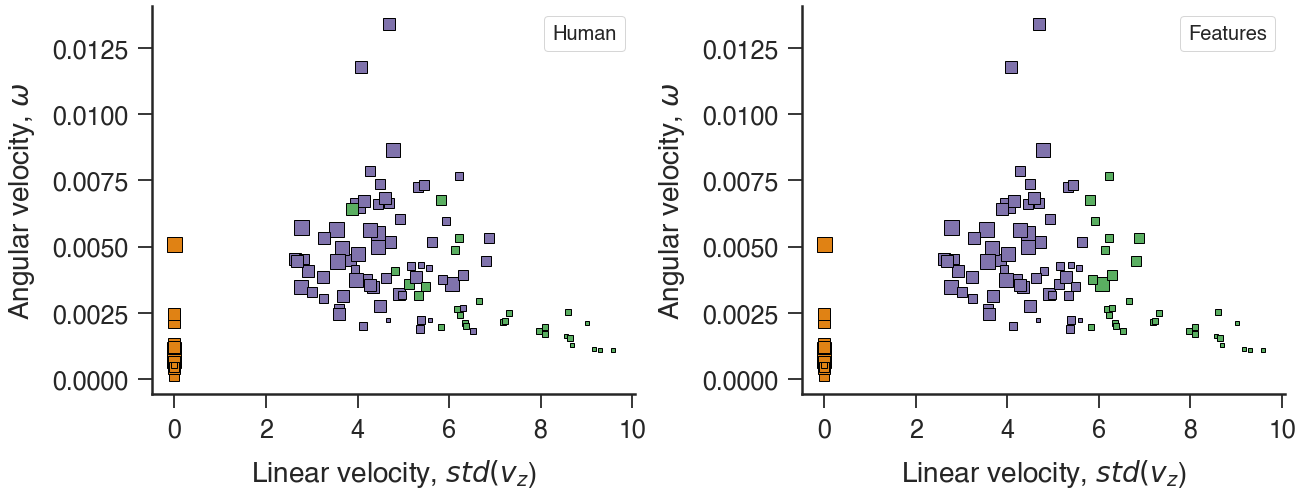

In [53]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"

#first panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_human_class, square_radii):
    if class_==1:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_feat_class, square_radii):
    if class_==1:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Square - Complexity-entropy or Fisher-Shannon plane

Text(0, 0.5, 'Relative frequency (pmf)')

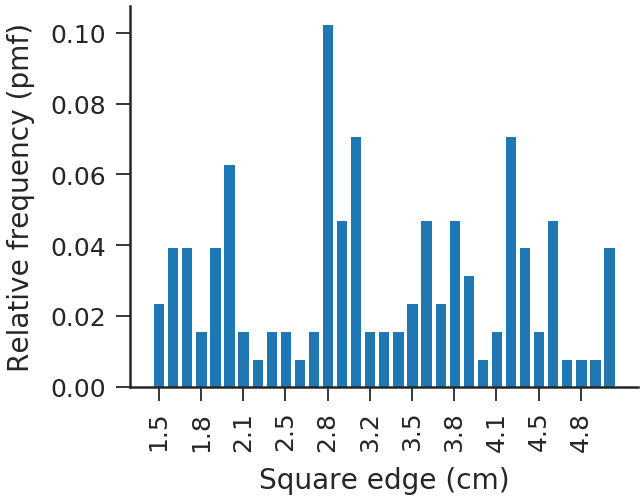

In [304]:
#Square size histogram
f, ax = plt.subplots()


x, y = np.unique(square_radii, return_counts=True)
y    = y/y.sum()


ax.bar(range(len(x)), y)
ax.set_xticks(range(len(x))[::3])

x = 100*x.round(decimals=3)[::3]
x = x.round(decimals=3)
ax.set_xticklabels(x.astype('str'), rotation=90)

ax.set_xlabel('Square edge (cm)')
ax.set_ylabel('Relative frequency (pmf)')

/home/arthur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


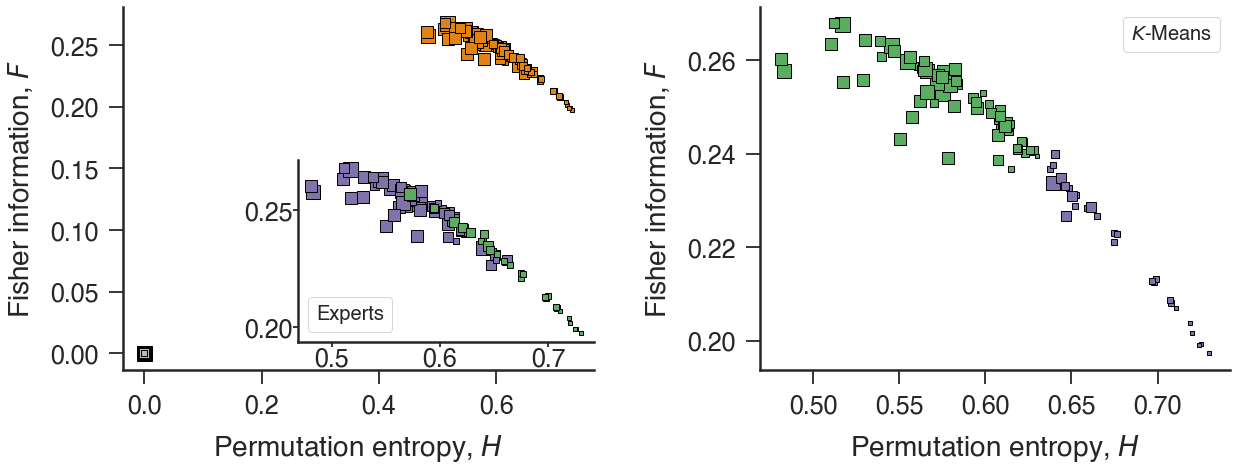

In [100]:
dx_                     = 3
square_ce               = []
square_cluster          = []
square_size             = []
square_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_trajectories, 
                                          square_cam1, square_cam2, square_human_class, square_radii):
    if class_==3:
        try:
            ts     = np.stack((ts1, ts2), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            square_ce.append((h_, c_))
        except:
            square_ce.append((np.nan, np.nan))
    else:
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        square_ce.append((h_, c_))
        square_cluster.append((h_, c_))
        square_size.append(size_)
        square_human_chaos_tumb.append(class_)
        

#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
axins = inset_axes(ax[0], width="90%", height="100%",
                   bbox_to_anchor=(.35, .05, .7, .5),
                   bbox_transform=ax[0].transAxes, loc=3)
axins.tick_params(length=5, pad=0)


# for (h_, c_), class_, size_ in zip(square_ce, square_feat_class, square_radius):
for (h_, c_), class_, size_ in zip(square_ce, square_human_class, square_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_)
        axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
        axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    if class_ == 3:
        try:
            ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_)
        except:
            pass
    
#calculation to generate second panel data
square_cluster          = np.asarray(square_cluster).reshape(-1,2)
scaler                  = StandardScaler()
square_cluster_features = scaler.fit_transform(square_cluster)
square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size):
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
    else:
        ax[1].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
axins.legend(['Experts'], loc='lower left', handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Fisher information, $F$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/auto-Fisher/Fisher-dx:{}-dims:{}'.format(dx_, 2), bbox_inches='tight')

In [251]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
np.where(square_feat_class==3)[0].flatten()==np.where(square_human_class==3)[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [330]:
_, b = np.unique(square_human_class[square_human_class!=3], return_counts=True)
b    = b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=1)[0]*100))
print('Chaotic  = {}%'.format(b.round(decimals=1)[1]*100), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
# # Agreement between the human and the permutation entropy classification (CE)
square_pred_copy = np.where(square_pred==1, 2, square_pred)
square_pred_copy = np.where(square_pred==0, 1, square_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy), '\n')
print('Accuracy of the original paper                          : ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]))

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 30.0%
Chaotic  = 70.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.8804347826086957 

Accuracy of the original paper                          :  0.8478260869565217


In [ ]:
print("dx=3, ~.880. dx=4, ~ .674. Acurácia de ~ .33. Pra dx=5 é ok (~ .79). Pra dx=6 a performance é um pouco pior (~ .69).")

# Vários valores de "embedding dimension" para a "câmera 1".
print("dx = 3, ~.869. dx = 4, ~.739. dx = 5, ~.783. dx=6, ~.739.")

# Vários valores de "embedding dimension" para a "câmera 2".
print("dx = 3, ~.826. dx = 4, ~.630. dx = 5, ~.652. dx=6, ~.652.")

## 3D - Square

## 3D - Square

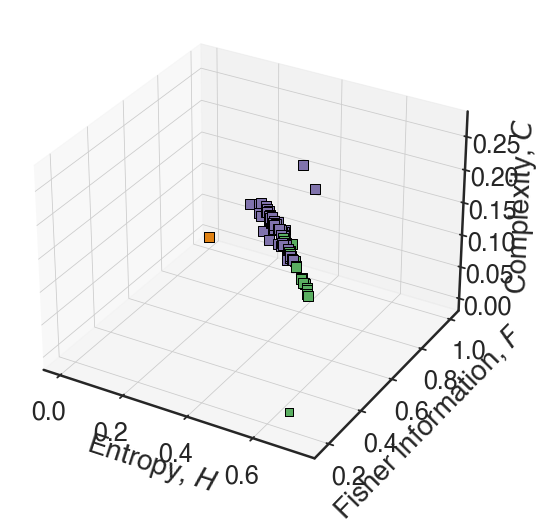

In [81]:
dx_ = 3

square_pe3d                  = []
square_pe3d_space            = []
square_pe3d_human_chaos_tumb = []

for i, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_cam1, 
                                      square_cam2, square_human_class, square_radii):
    if class_==3: #steady or periodic
        try:
            ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            square_pe3d.append((h_, f_, c_))
        except:
            square_pe3d.append((np.nan, np.nan))
            
    else: #chaotic or tumbling
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        square_pe3d.append((h_, f_, c_))
        square_pe3d_space.append((h_, f_, c_))
        square_pe3d_human_chaos_tumb.append(class_)

###################################################################        
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


orange_ = "#e08214" #3
purple_ = "#8073ac" #2
green_  = "#5aae61" #1
#(h_, f_, c_)
# for (x_, y_, z_), class_ in zip(square_pe3d, square_feat_class): 
for (x_, y_, z_), class_ in zip(square_pe3d, square_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='s', s=100, color=green_, edgecolor='black')
        ax.plot(h_, c_, '.', marker='s', markersize=8, markeredgecolor='black', color=green_, zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='s', s=100, color=purple_, edgecolor='black')
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color=orange_, edgecolor='black', zorder=0)
        except:
            pass

ax.set_xlabel('Entropy, $H$')
ax.set_ylabel('Fisher information, $F$')
ax.set_zlabel('Complexity, $C$')



#calculation to generate second panel data
square_pe3d_space = np.asarray(square_pe3d_space).reshape(-1,3)
square_pe3d_pred  = KMeans(n_clusters=2, random_state=42).fit(square_pe3d_space).labels_ 


f.tight_layout()

In [102]:
square_pe3d_pred_copy_plus_1 = square_pe3d_pred.copy()+1

sum(square_pe3d_human_chaos_tumb==square_pe3d_pred_copy_plus_1)/len(square_pe3d_pred_copy_plus_1)

0.18478260869565216

In [103]:
square_pe3d_pred_copy = np.where(square_pe3d_pred==0, 2, square_pe3d_pred)

sum(square_pe3d_human_chaos_tumb==square_pe3d_pred_copy)/len(square_pe3d_pred_copy)

0.8152173913043478

In [35]:
# pe3d_plane = np.asarray(pe3d_plane).reshape(-1, 3)
# Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

# f  = plt.figure()
# ax = f.add_subplot(111, projection='3d')


# #(h_, f_, c_)
# for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
#     if class_==0:
#         ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
#     else:
#         ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
# ax.set_ylabel('Fisher information, $F$')
# ax.set_xlabel('Entropy, $H$')

# f.tight_layout()

# Y_pred_full = square_feat_class.copy()
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)
# # y_pred_sub  = np.where(y_pred_sub==1, 0, y_pred_sub)

# k = 0
# for i, j in zip(square_feat_class, range(len(square_feat_class))):
#     if i==3:
#         pass
#     else:
#         Y_pred_full[j] = y_pred_sub[k]
#         k += 1

# sum(square_feat_class==square_human_class)/len(square_human_class)

# sum(Y_pred_full==square_human_class)/len(square_human_class)

0.4067796610169492

# Cross  Analysis

In [216]:
#loading cleaned trajectories and some features.
cross_trajectories, cross_cam1, cross_cam2, cross_radii, cross_width, cross_conditions, _  = trajectory_cleaning('Cross')
cross_dx, cross_dy, cross_dz, cross_pathlen, cross_time, cross_w, cross_vz                 = original_features(cross_trajectories, cross_cam1, cross_cam2)

In [217]:
#Classifications
cross_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Cross'))['behaviourHuman'][0]
cross_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Cross'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [183]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dx'].flatten()==np.asarray(cross_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dy'].flatten()==np.asarray(cross_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dz'].flatten()==np.asarray(cross_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['pathLength'].flatten(), cross_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['time'].flatten(), cross_time,
#                             range(len(cross_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Cross - Original features plane

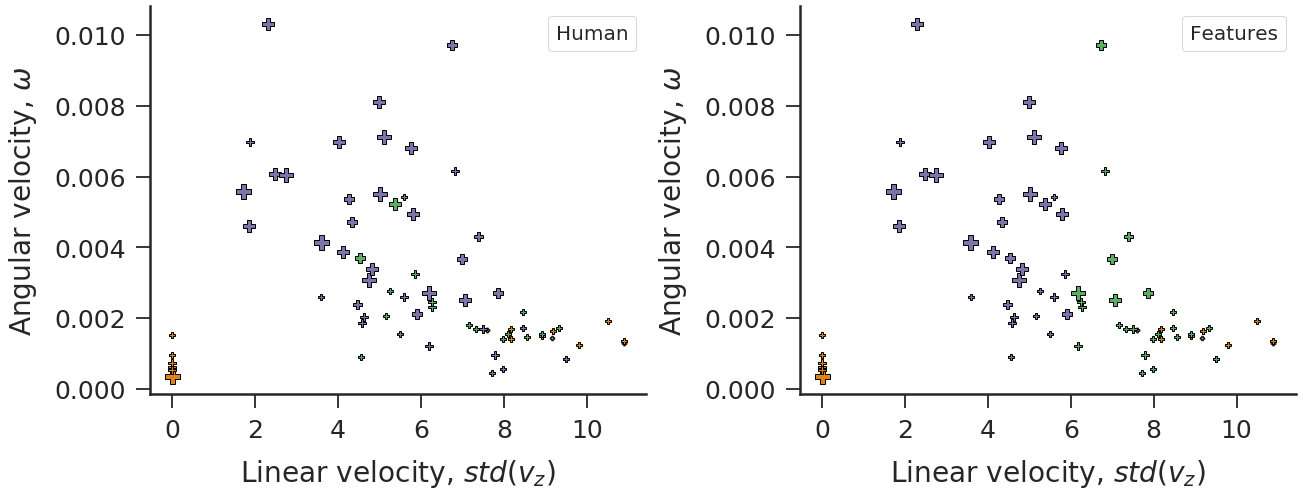

In [180]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

#first panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_human_class, cross_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_feat_class, cross_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Human'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Cross - Complexity-entropy or Fisher-Shannon plane

In [188]:
cross_trajectories[0]

array([[-0.01076438, -0.00154395,  1.06084113],
       [-0.01590085, -0.00243742,  1.04872827],
       [-0.02181073, -0.00357981,  1.03683191],
       [-0.02822544, -0.0049864 ,  1.02544917],
       [-0.03482548, -0.00664758,  1.01475106],
       [-0.04319779, -0.00801979,  1.00599695],
       [-0.05162679, -0.0093857 ,  0.99898095],
       [-0.05950045, -0.0106406 ,  0.99312676],
       [-0.06708065, -0.01171236,  0.98798663],
       [-0.07439941, -0.01252908,  0.98328142],
       [-0.07996696, -0.01358317,  0.97777567],
       [-0.0850911 , -0.01469245,  0.97155163],
       [-0.09052359, -0.01576687,  0.96504828],
       [-0.09586258, -0.01700378,  0.95832303],
       [-0.10136852, -0.01816737,  0.9519937 ],
       [-0.10779577, -0.01983195,  0.94664699],
       [-0.11317921, -0.02092546,  0.94155421],
       [-0.11834379, -0.02251862,  0.93559975],
       [-0.12321075, -0.02407102,  0.93063314],
       [-0.12729371, -0.02574648,  0.92540735],
       [-0.13151987, -0.0268144 ,  0.917

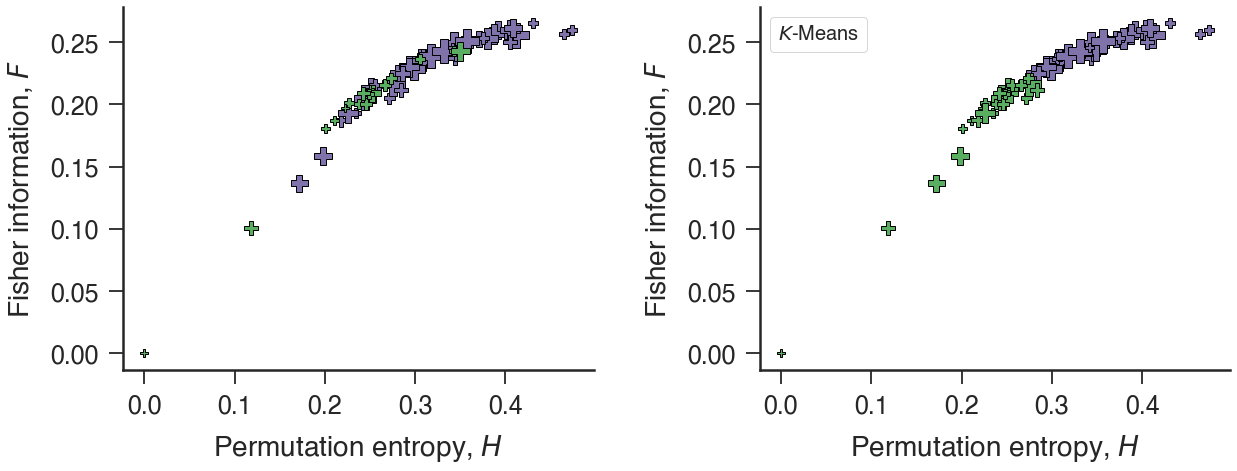

In [199]:
dx_                    = 4
cross_ce               = []
cross_cluster          = []
cross_size             = []
cross_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                          cross_cam1, cross_cam2, cross_human_class, cross_radii):   
    if class_==3:
        try:
#             ts     = np.stack((ts1, ts2), axis=1)
            ts = st
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            cross_ce.append((h_, c_))
        except:
            cross_ce.append((np.nan, np.nan))
    else:
#         ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        ts = st
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        cross_ce.append((h_, c_))
        cross_cluster.append((h_, c_))
        cross_size.append(size_)
        cross_human_chaos_tumb.append(class_)
    

#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)


for (h_, c_), class_, size_ in zip(cross_ce, cross_human_class, cross_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_)
#         axins.plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_)
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, zorder=0)
#         axins.plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, zorder=0)
    if class_ == 3:
        try:
            pass
#             ax[0].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=orange_)
        except:
            pass
    
#calculation to generate second panel data
cross_cluster          = np.asarray(cross_cluster).reshape(-1,2)
scaler                 = StandardScaler()
cross_cluster_features = scaler.fit_transform(X=cross_cluster)
cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_size):
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, zorder=0)
    else:
        ax[1].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
axins.legend(['Experts'], loc='lower left', handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Fisher information, $F$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/auto-Fisher/cross-Fisher-dx:{}-dims:{}'.format(dx_, 2), bbox_inches='tight', dpi=300)

In [200]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
np.where(cross_feat_class==3)[0].flatten()==np.where(cross_human_class==3)[0].flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [195]:
# cross_pred_copy_plus_1 = cross_pred.copy()+1

# sum(cross_human_chaos_tumb==cross_pred_copy_plus_1)/len(cross_pred_copy_plus_1)

In [201]:
_, b = np.unique(cross_human_class[cross_human_class!=3], return_counts=True)
b    = b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=1)[0]*100))
print('Chaotic  = {}%'.format(b.round(decimals=1)[1]*100), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
cross_pred_copy = np.where(cross_pred==0, 2, cross_pred)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(cross_human_chaos_tumb==cross_pred_copy)/len(cross_pred_copy))
print('Accuracy of the original paper                          : ', sum(cross_feat_class[cross_feat_class!=3]==cross_human_class[cross_human_class!=3])/len(cross_feat_class[cross_feat_class!=3]))

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 30.0%
Chaotic  = 70.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.7627118644067796
Accuracy of the original paper                          :  0.6440677966101694


In [17]:
print("dx = 3 e dx = 4 têm a mesma performance (~ .66) que é ligeiramente melhor. dx=5 e dx=6 têm resultados ruins, da ordem de .3.")

# Vários valores de "embedding dimension" para a "câmera 1".
print("dx = 3, ~.678. dx = 4, ~.305. dx = 5, ~.712. dx=6, ~.661.")

# Vários valores de "embedding dimension" para a "câmera 2".
print("dx = 3, ~.305. dx = 4, ~.559. dx = 5, ~.305. dx=6, ~.305.")

dx = 3 e dx = 4 têm a mesma performance (~ .66) que é ligeiramente melhor. dx=5 e dx=6 têm resultados ruins, da ordem de .3.
dx = 3, ~.678. dx = 4, ~.305. dx = 5, ~.712. dx=6, ~.661.
dx = 3, ~.305. dx = 4, ~.559. dx = 5, ~.305. dx=6, ~.305.


## 3D - Cross


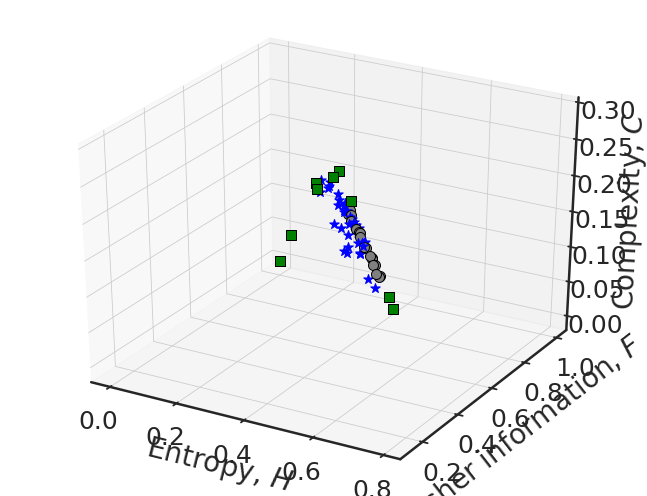

In [212]:
dx_ = 3

cross_pe3d                  = []
cross_pe3d_space            = []
cross_pe3d_human_chaos_tumb = []

for i, ts1, ts2, class_, size_ in zip(range(len(cross_trajectories)), cross_cam1, 
                                      cross_cam2, cross_human_class, cross_radii):
    if class_==3: #steady or periodic
        try:
            ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            cross_pe3d.append((h_, f_, c_))
        except:
            cross_pe3d.append((np.nan, np.nan))
            
    else: #chaotic or tumbling
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        cross_pe3d.append((h_, f_, c_))
        cross_pe3d_space.append((h_, f_, c_))
        cross_pe3d_human_chaos_tumb.append(class_)

###################################################################        
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

#(h_, f_, c_)
# for (x_, y_, z_), class_ in zip(cross_pe3d, cross_feat_class): 
for (x_, y_, z_), class_ in zip(cross_pe3d, cross_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color='grey', edgecolor='black')
#         ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='*', s=100, color='blue')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color='green', edgecolor='black', zorder=0)
        except:
            pass

ax.set_xlabel('Entropy, $H$')
ax.set_ylabel('Fisher information, $F$')
ax.set_zlabel('Complexity, $C$')



#calculation to generate second panel data
cross_pe3d_space = np.asarray(cross_pe3d_space).reshape(-1,3)
cross_pe3d_pred  = KMeans(n_clusters=2, random_state=42).fit(cross_pe3d_space).labels_ 


f.tight_layout()

In [64]:
cross_pe3d_pred_copy_plus_1 = cross_pe3d_pred.copy()+1

sum(cross_pe3d_human_chaos_tumb==cross_pe3d_pred_copy_plus_1)/len(cross_pe3d_pred_copy_plus_1)

0.576271186440678

In [65]:
cross_pe3d_pred_copy = np.where(cross_pe3d_pred==0, 2, cross_pe3d_pred)

sum(cross_pe3d_human_chaos_tumb==cross_pe3d_pred_copy)/len(cross_pe3d_pred_copy)

0.423728813559322

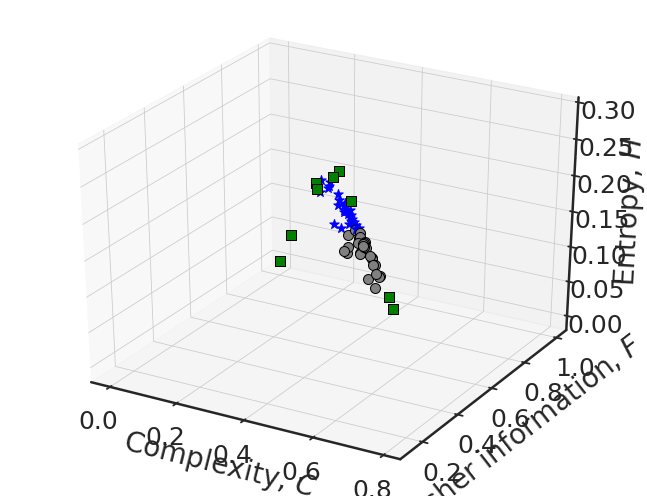

In [214]:
dx_ = 3

pe3d       = []
pe3d_plane = []

for i, st, ts1, ts2, class_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                   cross_cam1, cross_cam2, cross_feat_class):
    if class_==3:
        try:
            ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            cross_ce.append((np.nan, np.nan))
    else:

        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_plane.append((h_, f_, c_))

f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

#(h_, f_, c_)
for (x_, y_, z_), class_ in zip(pe3d, cross_feat_class): 
# for (x_, y_, z_), class_ in zip(pe3d, cross_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color='grey', edgecolor='black')
#         ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='*', s=100, color='blue')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color='green', edgecolor='black', zorder=0)
        except:
            pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Complexity, $C$')
ax.set_zlabel('Entropy, $H$')

f.tight_layout()

In [215]:
pe3d_plane = np.asarray(pe3d_plane).reshape(-1, 3)
Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

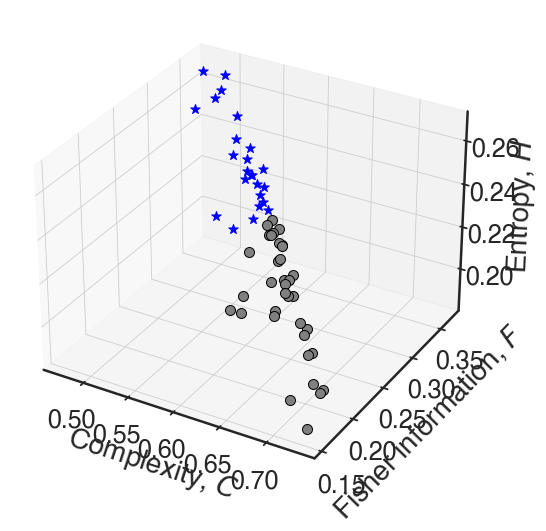

In [27]:
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


#(h_, f_, c_)
for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
    if class_==0:
        ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
    else:
        ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Complexity, $C$')
ax.set_zlabel('Entropy, $H$')

f.tight_layout()

In [216]:
Y_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int32)

In [217]:
Y_pred_full = cross_feat_class.copy()
y_pred_sub  = Y_pred+1
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)

k = 0
for i, j in zip(cross_feat_class, range(len(cross_feat_class))):
    if i==3:
        pass
    else:
        Y_pred_full[j] = y_pred_sub[k]
        k += 1

In [218]:
sum(cross_feat_class==cross_human_class)/len(cross_human_class)

0.7162162162162162

In [219]:
sum(Y_pred_full==cross_human_class)/len(cross_human_class)

0.6621621621621622

# Figures

In [202]:
# f, ax = plt.subplots(nrows=3, ncols=2, figsize=stdfigsize(scale=.9, nrows=3, ncols=2))
# ax    = ax.flatten()

# orange_ = "#e08214"
# purple_ = "#8073ac"
# green_  = "#5aae61"
# grey_   = "#bababa"

# #first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(circle_ce, circle_human_class, circle_radii): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     if class_ == 3:
#         if not k==0:
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')
            
# ax[0].legend(loc=[.01,.76], handletextpad=0)
# axins.legend(handletextpad=0)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
        
    
# #second panel
# axins = inset_axes(ax[1], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[1].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# #second panel
# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size):
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     if class_ == 3:
#         if not k==0:
#             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1            ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')
            
# ax[1].legend(loc=[.01,.76], handletextpad=0)
# axins.legend(handletextpad=0)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
# #     if class_==0:
# #         if not i==0:
# #             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
# #         else:
# #             i+=1
# #             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
# #     else:
# #         if not j==0:
# #             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)    
# #         else:
# #             j+=1
# #             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', label='Tumbling', color=green_)    

# # ax[1].legend(handletextpad=0)
# # ax[1].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
# #                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

# for i in range(2):
#     ax[i].set_ylabel('Statistical complexity, $C$')
#     ax[i].set_xlabel('Permutation entropy, $H$')    
    
    
# #third panel
# axins = inset_axes(ax[2], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[2].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(square_ce, square_human_class, square_radii): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[2].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[2].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[2].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)    
#     if class_ == 3:
#         if not k==0:
#             ax[2].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[2].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')        
            
# ax[2].legend(loc=[.01,.76], handletextpad=0)
# axins.legend(handletextpad=0)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
                    
# #fourth panel    
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size):
#     if class_==1:
#         if not i==0:
#             ax[3].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[3].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[3].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[3].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', label='Tumbling', color=green_)    
    
# ax[3].legend(handletextpad=0)
# ax[3].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

# for i in range(2,4):
#     ax[i].set_ylabel('Statistical complexity, $C$')
#     ax[i].set_xlabel('Permutation entropy, $H$')
    
# #fifth panel
# axins = inset_axes(ax[4], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[4].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(cross_ce, cross_human_class, np.asarray(cross_radii)): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[4].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[4].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[4].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)            
#     if class_ == 3:
#         if not k==0:
#             ax[4].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[4].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=grey_, label='Steady')        
# ax[4].legend(loc=[.01,.76], handletextpad=0)
# axins.legend(handletextpad=0)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
    
# #sixth panel
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_size):
#     if class_==0:
#         if not i==0:
#             ax[5].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[5].plot(h_, c_, '.', marker='P', markersize=500*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[5].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[5].plot(h_,c_,  '.', marker='P', markersize=500*size_, markeredgecolor='black', label='Tumbling', color=green_)    
    
# ax[5].legend(handletextpad=0)
# ax[5].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
        

# for i in range(4,6):
#     ax[i].set_ylabel('Statistical complexity, $C$')
#     ax[i].set_xlabel('Permutation entropy, $H$')
    
    
# f.tight_layout(w_pad=3)
# f.savefig('figures/final_figures/complexity_entropy_all_shapes.pdf', bbox_inches='tight')